<a href="https://colab.research.google.com/github/Kalbar1234/PRA3024/blob/main/Assingment2_GravitationalWaves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**

In [10]:
import sys

#instal pyCBC module
!{sys.executable} -m pip install lalsuite pycbc

#download time series from the H1 and L1 detectors 
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf

File ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.

File ‘L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.



In [11]:
from __future__ import division

import numpy
import lal
import lalsimulation

import matplotlib.pyplot as plt
from pycbc.conversions import *
from astropy import cosmology
from pycbc import waveform
from numpy import arange 

from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass, lowpass_fir, match, matched_filter
from pycbc.frame import read_frame

import pylab

from pycbc.waveform import get_td_waveform
from pycbc.waveform import get_fd_waveform

from pycbc.psd import interpolate, inverse_spectrum_truncation, welch, aLIGOZeroDetHighPower, EinsteinTelescopeP1600143

import pycbc.types 

import pycbc.noise
import pycbc.filter
import pycbc.waveform

from statistics import mean, stdev
from pycbc.filter import sigmasq
from scipy.stats import norm


# Problem 1

In [12]:
#select the desired event
merger = Merger("GW170817")

#variables for the second problem
strain, stilde, psds = {}, {}, {}

masses = numpy.arange(1, 3, .05)
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = []

#variables for the third problem
f_low = 30
sample_rate = 4096
matches = {}

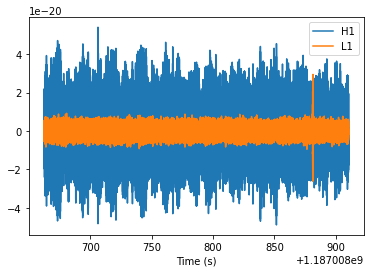

In [13]:
#load the data, select the time window in which the event is happening, remove the lower frequencies, crop the timeseries to eliminate the 
#filter wraparound effect and create a frequency domain
for ifo in ['L1', 'H1']:
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(ifo[0], ifo),
                    '{}:LOSC-STRAIN'.format(ifo),
                    start_time=merger.time - 224,
                   end_time=merger.time + 32,
                   check_integrity=False)

    strain[ifo] = resample_to_delta_t(highpass(ts, 15.0), 1.0/2048)
    strain[ifo] = strain[ifo].crop(4, 4)
    stilde[ifo] = strain[ifo].to_frequencyseries()

pylab.plot(strain["H1"].sample_times, strain["H1"], label = "H1")
pylab.plot(strain["L1"].sample_times, strain["L1"], label = "L1")
pylab.xlabel('Time (s)')
pylab.legend()
pylab.show()

0.004032258064516129

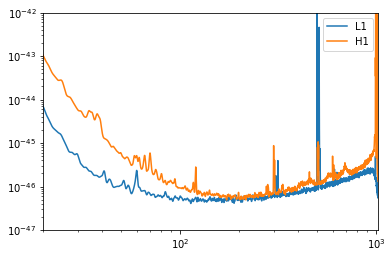

In [14]:
#load the power spectrum densities for both detectors 
for ifo in ['L1', 'H1']:

  psds[ifo] = interpolate(strain[ifo].psd(2), strain[ifo].delta_f)

  psds[ifo] = inverse_spectrum_truncation(psds[ifo], int(2 *strain[ifo].sample_rate),
                                          low_frequency_cutoff=15.0,
                                          trunc_method='hann')
  
  pylab.loglog(psds[ifo].sample_frequencies, psds[ifo], label=ifo)
  pylab.xlim(20, 1024)
  pylab.ylim(1e-47, 1e-42)

pylab.legend()
psds[ifo].delta_f

In [ ]:
#iterate thru different masses to check which yields the best results 
for m in masses:
  hp, hc = get_fd_waveform(approximant="TaylorF2",
                          mass1=m,
                          mass2=m,
                          delta_f=stilde[ifo].delta_f,
                          f_lower=20)
  
  hp.resize(len(stilde[ifo]))

  # Matched filter the data and find the peak
  max_snr, max_time = {}, {}

  for ifo in ['H1', 'L1']:
    snr = matched_filter(hp, stilde[ifo], 
                          psd=psds[ifo],
                          low_frequency_cutoff=20)
    
    # The complex SNR at the peak
    snr = snr.time_slice(merger.time - 1, merger.time + 1)
    _, idx = snr.abs_max_loc()
    max_snr[ifo] = snr[idx]
    
    # The time of the peak
    max_time[ifo] = float(idx) / snr.sample_rate + snr.start_time

    network_snr = (abs(numpy.array(list(max_snr.values()))) ** 2.0).sum()** 0.5
    snrs.append(max_snr)

  # Keep track of only the loudest peak

    if network_snr > nsnr:
      tmax, hmax, mmax, smax = max_time, hp, m, max_snr
      nsnr = network_snr

print("We found the best Mass1=Mass2 was %2.2f solar masses (detectorframe)" % mmax)

We found the best Mass1=Mass2 was 1.35 solar masses (detectorframe)


In [ ]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.
ifo = 'L1'
template = hmax.cyclic_time_shift(hmax.start_time)

# Shift the template to the peak time
dt = tmax[ifo] - strain[ifo].start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psds[ifo], low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * nsnr).to_timeseries()
aligned.start_time = strain[ifo].start_time

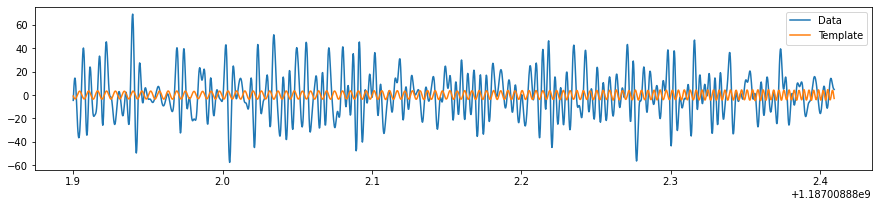

In [ ]:
# We do it this way so that we can whiten both the template and the data
white_data = (strain[ifo].to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

# apply a smoothing of the turnon of the template to avoid a transient
# from the sharp turn on in the waveform.
tapered = aligned.highpass_fir(15, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

white_data = white_data.highpass_fir(30, 512).lowpass_fir(300, 512)
# white_template = white_template.highpass_fir(15, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(merger.time-0.5, merger.time+0.01)
white_template = white_template.time_slice(merger.time-0.5, merger.time+0.01)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

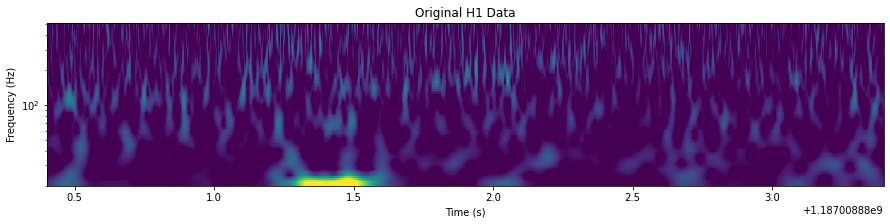

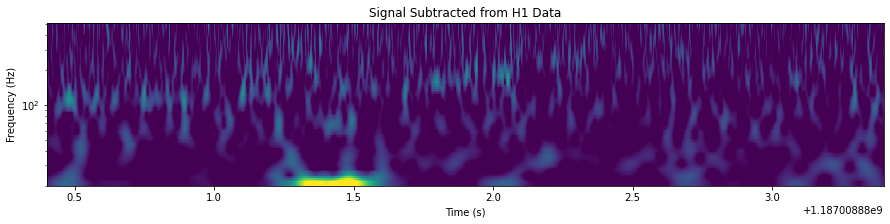

In [ ]:
subtracted = strain[ifo] - aligned

# Plot the original data and the subtracted signal data

for data, title in [(strain[ifo], 'Original H1 Data'),
                    (subtracted, 'Signal Subtracted from H1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001,
                                                  logfsteps=100,
                                                  qrange=(8, 8),
                                                  frange=(20, 512))
    pylab.figure(figsize=[15, 3])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    pylab.yscale('log')
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(merger.time - 2, merger.time + 1)
    pylab.show()


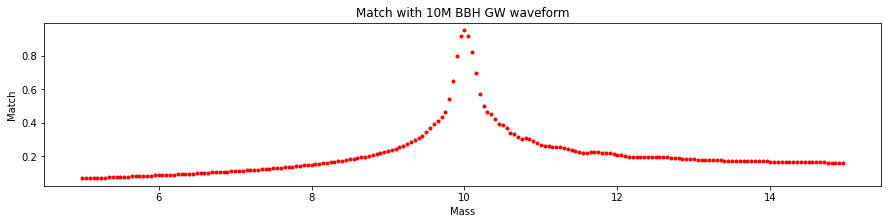

In [ ]:
masses = arange(5,15,0.05)

#iterate thru different masses to check how the generated waveforms compare to each other 
for mass in masses:
  # Generate the two waveforms to compare
  hp, hc = get_td_waveform(approximant="EOBNRv2",
                          mass1=10,
                          mass2=10,
                          f_lower=f_low,
                          delta_t=1.0/sample_rate)

  sp, sc = get_td_waveform(approximant="TaylorT4",
                          mass1=mass,
                          mass2=mass,
                          f_lower=f_low,
                          delta_t=1.0/sample_rate)

  # Resize the waveforms to the same length
  tlen = max(len(sp), len(hp))
  sp.resize(tlen)
  hp.resize(tlen)

  # Generate the aLIGO ZDHP PSD
  delta_f = 1.0 / sp.duration
  flen = tlen//2 + 1
  psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

  m, i = match(hp, sp, psd=psd, low_frequency_cutoff=f_low)
  matches[mass]=m

# from the graph it can be concluded that the closer the masses of the waveform generations are the more similair they are
pylab.figure(figsize=[15, 3])
pylab.title("Match with 10M BBH GW waveform")
pylab.ylabel('Match')
pylab.xlabel('Mass')
pylab.plot(*zip(*matches.items()),'r.')
pylab.show()

# Problem 2 

In [ ]:
# variables
flow = 30 #Hz

interval = 0.05
masses = arange(5,10,interval)

maxSNR = 0
pltSNR = 0
maxhp = 0

SNRlist = []

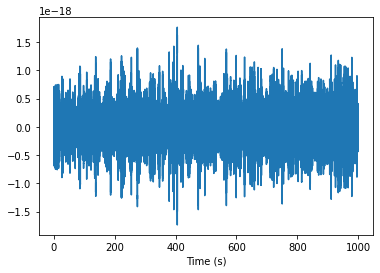

In [ ]:
# oad the data 
d = numpy.load('noise_ts_4096Hz.npy')
dt = d[:, 0]
d = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0])
data = d

# view the data
pylab.plot(data.sample_times, data)
pylab.xlabel('Time (s)')
pylab.show()

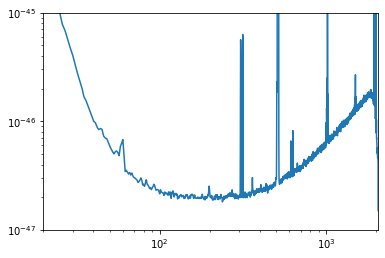

In [ ]:
#create the power spectrum density for the data
psds = interpolate(welch(d), 1.0 / d.duration)

#plot the psd
pylab.loglog(psds.sample_frequencies, psds)
pylab.xlim(20, max(psds.sample_frequencies))
pylab.ylim(1e-47, 1e-45)
pylab.show()

Maximum SNR: 6.54525735364218. No gravitational wave detected.


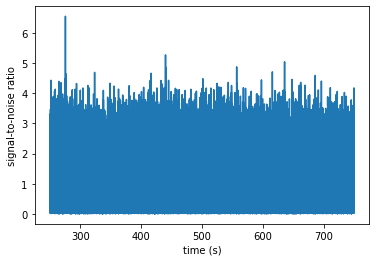

In [ ]:
stilde = data.to_frequencyseries()

#iterate thru masses to check if a gravitational wave is present in the data by calculating the SNR 
for m in masses:

  hp, hc = get_fd_waveform(approximant="TaylorF2",
                           mass1=m, mass2=m,
                           f_lower=flow, delta_f=stilde.delta_f)

  hp.resize(len(stilde))  
  snr = matched_filter(hp, stilde, psd=psds,
                       low_frequency_cutoff=flow)


  # Remove regions corrupted by filter wraparound
  snr = snr[len(snr) // 4: len(snr) * 3 // 4]
 
  if max(abs(snr)) > maxSNR:
    maxSNR = max(abs(snr))
    pltSNR = snr
    maxhp = hp

# Checking if the gravtiational wave singal is present in the data 
if maxSNR < 8: 
  print("Maximum SNR: {}. No gravitational wave detected.".format(maxSNR))
else:
  print("Maximum SNR: {}. Gravitational wave detected.".format(maxSNR))

#plotting the SNR complex with the highest SNR peak
pylab.plot(pltSNR.sample_times, abs(pltSNR))
pylab.ylabel('signal-to-noise ratio')
pylab.xlabel('time (s)')
pylab.show()

In [ ]:
#whitening the data 
white_data = (data.to_frequencyseries() / psds**0.5).to_timeseries()
white_data = white_data.crop(4,4)

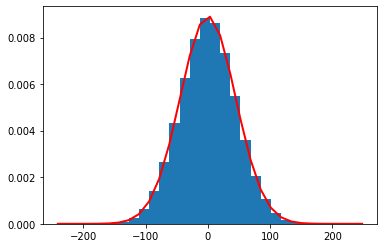

In [ ]:
#calculating the mean and standard deviation
mu, sigma = mean(white_data), stdev(white_data)

#number of observations
shape = white_data.shape[0]

s = numpy.random.normal(mu, sigma, shape)

count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins,
         1/(sigma * numpy.sqrt(2 * numpy.pi)) * numpy.exp( - (bins - mu)**2 / (2 * sigma**2) ), 
         linewidth=2, color='r')
plt.show()

In [ ]:
#preparing the hp for the optimal SNR
hp, hc = get_fd_waveform(approximant="TaylorF2",
                         mass1=3,
                         mass2=3,
                         delta_f=1.0/(200.0),
                         distance = 500,
                         f_lower=20.0,
                         f_final = 2048.0)

In [ ]:
#splitting the data into equal intervals 
intervals = 1000
data_slice = int(len(data)/intervals)

#generating an optimal SNR for each part of the data
for i in range(0, intervals):

  data_chunk = data[i * data_slice: (i+1)*data_slice]

  psds = interpolate(welch(data_chunk), hp.delta_f)

  SNR = (sigmasq(hp, psds))**0.5

  SNRlist.append(SNR)

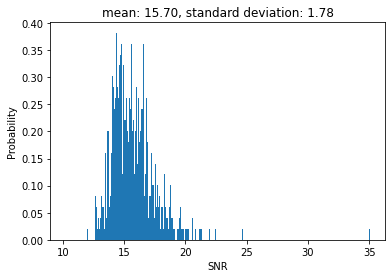

In [ ]:
mu, sigma = mean(SNRlist), stdev(SNRlist)

#plotting the graph
plt.hist(SNRlist, bins = 500, density=True)
y = norm.pdf(25, mu, sigma)
plt.plot(25, y)

plt.title('mean: {:.2f}, standard deviation: {:.2f}'.format(mu, sigma))
plt.xlabel("SNR")
plt.ylabel("Probability")

plt.show()

#The graph does not follow normal distrubtion which is proof that the noise doesn't follow stationary distribiution 

# Problem 3 

In [ ]:
#variables
flow = 4.0 # set up the lower cut off frequency
delta_f = 1.0 / 16

flen = int(2048.0/ (delta_f)) + 1

interval = 1
masses = arange(5,500,interval)

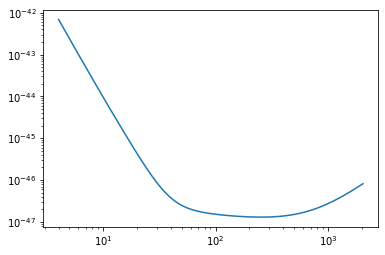

In [ ]:
psd = aLIGOZeroDetHighPower(flen, delta_f, flow)

psd.data[:int(flow/delta_f)] = numpy.inf #set the value outside the frequency range to infinity
psd.data[-1] = numpy.inf

pylab.loglog(psd.sample_frequencies, psd)
pylab.show()

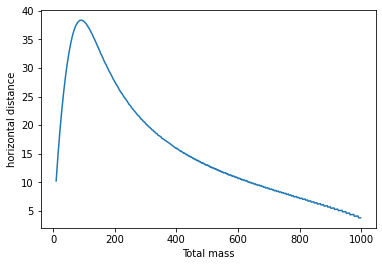

In [ ]:
yplot = []
xplot = []

for m in masses:
  hp, hc = get_fd_waveform(approximant="TaylorF2",
                           mass1=m, mass2=m,
                           f_lower=flow, 
                           delta_f=delta_f,
                           distance = 1000)

  SNR = (sigmasq(hp, psd))**0.5

  yplot.append(SNR)
  xplot.append(m*2)

pylab.plot(xplot, yplot)
pylab.ylabel('horizon distance')
pylab.xlabel('Total mass')
pylab.show()


**3.2:  By increasing the horizon distance it is easier to detect a certain event because the SNR at a fixed distance is higher for events with highest horizon distance than for events with lower horizon distance. This means that for example if the total mass is 50 for one event and the total mass for the second event is around 150 then from the graph we can conclude that the SNR for the second event will be much higher than for the first event. 

However at certain mass the horizon distance starts to decrease. This is because the aLigo detector has a frequency band which means that it is more senstiitve to a certain range of frequencies than other. If the event happens at frequencies that are higher than the detector range then the SNR will be lower which explains why the horizon distance decrease with the mass because the heavier objects will produce higher frequencies. 

By comparing the aLigo detector with the Einstein telescope it can be concluded that the latter is more senstive than the former because the curve is shifted towards to heavier objects. 

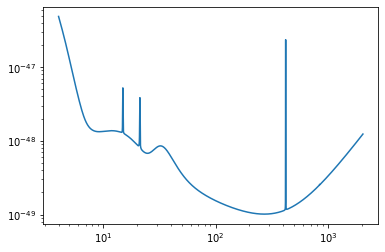

In [ ]:
psd = EinsteinTelescopeP1600143(flen, delta_f, flow)

psd.data[:int(flow/delta_f)] = numpy.inf #set the value outside the frequency range to infinity
psd.data[-1] = numpy.inf

# print(psd.sample_frequencies)
pylab.loglog(psd.sample_frequencies, psd)
pylab.show()

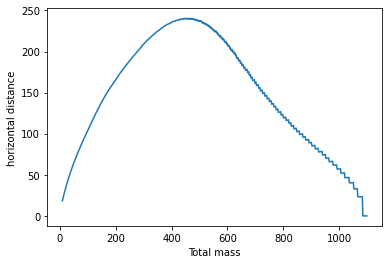

In [ ]:
yplot = []
xplot = []

for m in masses:
  hp, hc = get_fd_waveform(approximant="TaylorF2",
                           mass1=m, mass2=m,
                           f_lower=flow, 
                           delta_f=delta_f,
                           distance = 1000)

  SNR = (sigmasq(hp, psd))**0.5
  
  yplot.append(SNR/8)
  xplot.append(m*2)

pylab.plot(xplot, yplot)
pylab.ylabel('horizon distance')
pylab.xlabel('Total mass')
pylab.show()